Solving NER problem using **BiLSTM-CRF** model

Bidirectional Long-Short Term Memory (BiLSTM) - Conditional random field (CRF)

# Preparing

In [40]:
import os
import re
import pickle
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, optimizers
import tensorflow_addons as tfa
from tensorflow_addons.layers import CRF
# from tensorflow_addons.text import crf_log_likelihood
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW


In [41]:
%pip install tensorflow-addons


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Extract X,Y from bio files

In [42]:
def read_bio_file(file_path):
    """
    Extract X (tokens) and Y (labels) from a BIO file, splitting sentences by '.'
    """
    tokens = []
    labels = []
    current_tokens = []
    current_labels = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:  # Non-empty line
                token, label = line.split()
                current_tokens.append(token)
                current_labels.append(label)
                
                # Check if the token is a period '.' at the end of a sentence
                if re.match(r'^\.$', token) and len(current_tokens) > 1 and re.match(r'^[1-9]$', current_tokens[-2]):
                    pass # this is pattern of type: (1 ., 2 .)
                elif re.match(r'^\.$', token):  
                    tokens.append(current_tokens)
                    labels.append(current_labels)
                    current_tokens = []
                    current_labels = []

    
    # Append the remaining tokens/labels if any
    if current_tokens:
        tokens.append(current_tokens)
        labels.append(current_labels)
    
    return tokens, labels

def read_multi_bio_files(directory_path):
    """
    Read all BIO files in a directory and extract X and Y, separating sentences by periods.
    """
    all_X = []  # List of all tokenized notes
    all_Y = []  # List of all labels
    
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        
        # Skip non-text files
        if not file_name.endswith('.bio'):
            continue
        
        print(f"Processing file: {file_name}")
        file_X, file_Y = read_bio_file(file_path)
        all_X.extend(file_X)
        all_Y.extend(file_Y)
    
    return all_X, all_Y

X, Y 2 dim lists

- first dim represents sentences
- second dim represents words

In [43]:
# Example usage
directory_path = "bio/"
X, Y = read_multi_bio_files(directory_path)

Processing file: note_1.bio
Processing file: note_10.bio
Processing file: note_100.bio
Processing file: note_1000.bio
Processing file: note_10000.bio
Processing file: note_10001.bio
Processing file: note_10002.bio
Processing file: note_10003.bio
Processing file: note_10004.bio
Processing file: note_10005.bio
Processing file: note_10006.bio
Processing file: note_10007.bio
Processing file: note_10008.bio
Processing file: note_10009.bio
Processing file: note_1001.bio
Processing file: note_10010.bio
Processing file: note_10011.bio
Processing file: note_10012.bio
Processing file: note_10013.bio
Processing file: note_10014.bio
Processing file: note_10015.bio
Processing file: note_10016.bio
Processing file: note_10017.bio
Processing file: note_10018.bio
Processing file: note_10019.bio
Processing file: note_1002.bio
Processing file: note_10020.bio
Processing file: note_10021.bio
Processing file: note_10022.bio
Processing file: note_10023.bio
Processing file: note_10024.bio
Processing file: not

In [44]:
# Output
print(f"Number of sentences: {len(X):,}")
print("Sample X (tokens):", X[:10])  # First 10 sentences
print("Sample Y (labels):", Y[:10])  # Corresponding labels

Number of sentences: 305,731
Sample X (tokens): [['clinical', 'notes', '.'], ['patient', 'information', ':', 'age', ':', '41', 'years', 'old', 'gender', ':', 'male', '.'], ['visit', 'motivation', ':', 'anemia', 'evaluation', '.'], ['chief', 'complaints', 'and', 'symptoms', ':', 'the', 'patient', 'presents', 'with', 'complaints', 'of', 'anemia', ',', 'fever', ',', 'fatigue', ',', 'difficulty', 'breathing', '(', 'dyspnea', ')', ',', 'vomiting', ',', 'dizziness', ',', 'blurred', 'vision', ',', 'wheezing', ',', 'and', 'pale', 'skin', '.'], ['the', 'patient', 'reports', 'that', 'these', 'symptoms', 'have', 'been', 'progressively', 'worsening', 'over', 'the', 'past', 'few', 'weeks', '.'], ['.'], ['history', 'of', 'present', 'illness', ':', 'fever', ':', 'intermittent', 'low', 'grade', 'fevers', 'for', 'approximately', '2', 'weeks', '.'], ['fatigue', ':', 'persistent', 'and', 'severe', 'fatigue', 'affecting', 'daily', 'activities', '.'], ['difficulty', 'breathing', '(', 'dyspnea', ')', ':', '

# EDA

Number of sentences and words in the data

In [45]:
# Calculate the number of words per sentence
words_per_sentence = [len(sentence) for sentence in X]

print(f"Total number of sentences: {len(X):,}")
print(f"Total number of words: {sum(words_per_sentence):,}")

Total number of sentences: 305,731
Total number of words: 4,489,155


Min & Max sentence lenght

In [46]:
print(f"Min words per sentence: {min(words_per_sentence)}")
print(f"Max words per sentence: {max(words_per_sentence)}")

Min words per sentence: 1
Max words per sentence: 169


Bar of sentences lenght

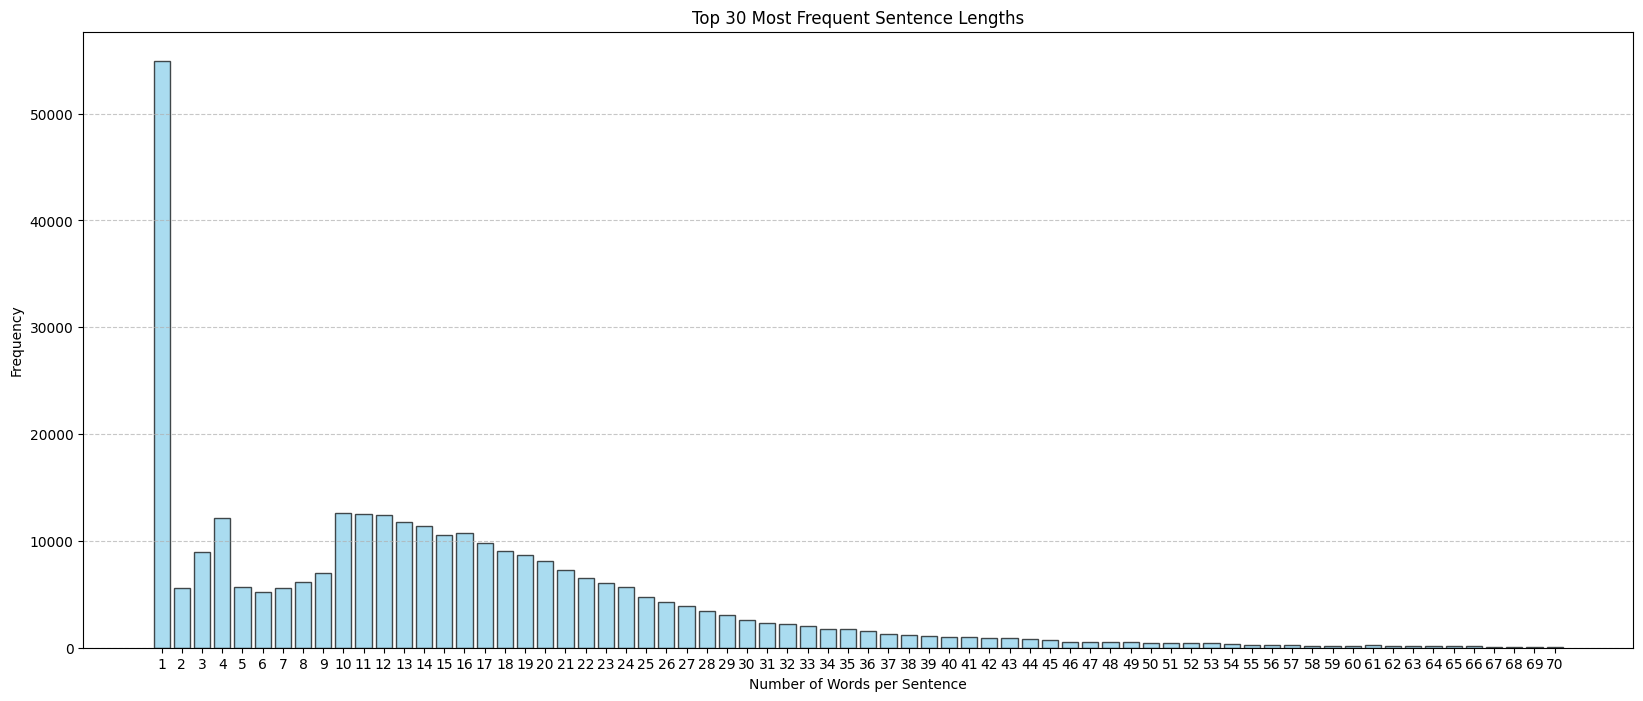

In [47]:
# Count the frequency of each word count
word_count_freq = Counter(words_per_sentence)

# Select the 20 most frequent word counts
most_common_counts = word_count_freq.most_common(70)
most_common_counts = sorted(most_common_counts)  # Sort by word count for better visualization

# Split into two lists for plotting
word_counts, frequencies = zip(*most_common_counts)

# Plot the distribution
plt.figure(figsize=(20, 8))
plt.bar(word_counts, frequencies, color="skyblue", edgecolor="black", alpha=0.7)

# Add labels and title
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.title("Top 30 Most Frequent Sentence Lengths")
plt.xticks(word_counts)

# Show the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Discovering why there's too many small sentences (with one word)

In [48]:
one_word_sentences = [sentence for sentence in X if len(sentence) == 1]
words = [sentence[0] for sentence in one_word_sentences] # Flatten the list
print(Counter(words))

Counter({'.': 54921, ']': 3, 'urinalysis': 1, ')': 1})


drop them

In [49]:
new_X = [sentence for sentence in X if len(sentence) != 1]
new_Y = [sentence for sentence in Y if len(sentence) != 1]

In [50]:
print(f"Total number of sentences for new_X: {len(new_X):,}")
print(f"Total number of sentences for new_Y: {len(new_Y):,}")

# Calculate the number of words per sentence
words_per_sentence1 = [len(sentence) for sentence in new_X]
words_per_sentence2 = [len(sentence) for sentence in new_Y]

print(f"\nTotal number of words for new_X: {sum(words_per_sentence1):,}")
print(f"Total number of words for new_Y: {sum(words_per_sentence2):,}")

Total number of sentences for new_X: 250,805
Total number of sentences for new_Y: 250,805

Total number of words for new_X: 4,434,229
Total number of words for new_Y: 4,434,229


In [51]:
print(new_X[:100])
print(new_Y[:100])

[['clinical', 'notes', '.'], ['patient', 'information', ':', 'age', ':', '41', 'years', 'old', 'gender', ':', 'male', '.'], ['visit', 'motivation', ':', 'anemia', 'evaluation', '.'], ['chief', 'complaints', 'and', 'symptoms', ':', 'the', 'patient', 'presents', 'with', 'complaints', 'of', 'anemia', ',', 'fever', ',', 'fatigue', ',', 'difficulty', 'breathing', '(', 'dyspnea', ')', ',', 'vomiting', ',', 'dizziness', ',', 'blurred', 'vision', ',', 'wheezing', ',', 'and', 'pale', 'skin', '.'], ['the', 'patient', 'reports', 'that', 'these', 'symptoms', 'have', 'been', 'progressively', 'worsening', 'over', 'the', 'past', 'few', 'weeks', '.'], ['history', 'of', 'present', 'illness', ':', 'fever', ':', 'intermittent', 'low', 'grade', 'fevers', 'for', 'approximately', '2', 'weeks', '.'], ['fatigue', ':', 'persistent', 'and', 'severe', 'fatigue', 'affecting', 'daily', 'activities', '.'], ['difficulty', 'breathing', '(', 'dyspnea', ')', ':', 'experiencing', 'shortness', 'of', 'breath', ',', 'parti

# X, Y pickle files

Save

In [26]:
# Save X to a pickle file
with open("ner_x.pkl", "wb") as pkl_file:
    pickle.dump(new_X, pkl_file)

with open("ner_y.pkl", "wb") as pkl_file:
    pickle.dump(new_Y, pkl_file)

Load

In [52]:
# To load it back later
with open("ner_x.pkl", "rb") as pkl_file:
    X = pickle.load(pkl_file)

with open("ner_y.pkl", "rb") as pkl_file:
    Y = pickle.load(pkl_file)

## Unique X, Y

In [53]:
# Flatten the 3D list into a 1D list
flattened_Y = [label for sentence in Y for label in sentence]

# Count unique values
unique_counts = Counter(flattened_Y)

# Print the result
print(unique_counts)

Counter({'O': 3759987, 'B-SYMPTOM': 230094, 'I-SYMPTOM': 129286, 'B-BODY_MEASURE': 73736, 'I-BODY_MEASURE': 46278, 'B-UNIT': 44452, 'B-VISIT_MOTIVATION': 42588, 'B-VALUE': 42000, 'I-VISIT_MOTIVATION': 38868, 'B-AGE': 13494, 'B-GENDER': 13446})


In [54]:
# Flatten the list of lists and get unique words
unique_words = set(word for sentence in X for word in sentence)

# Count the number of unique words
unique_word_count = len(unique_words)

print(f"Number of unique words: {unique_word_count:,}")

Number of unique words: 10,211


# Prepare model input & output

In [55]:
print(X[:3])
print(Y[:3])

[['clinical', 'notes', '.'], ['patient', 'information', ':', 'age', ':', '41', 'years', 'old', 'gender', ':', 'male', '.'], ['visit', 'motivation', ':', 'anemia', 'evaluation', '.']]
[['O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'B-AGE', 'O', 'O', 'O', 'O', 'B-GENDER', 'O'], ['O', 'O', 'O', 'B-VISIT_MOTIVATION', 'O', 'O']]


Define **training_data**: create tuples of X, Y 

In [56]:
# Combine each word with its label in each sentence
training_data = [
    [(word, label) for word, label in zip(sentence, labels)]
    for sentence, labels in zip(X, Y)
]

In [57]:
print(training_data[:3])

[[('clinical', 'O'), ('notes', 'O'), ('.', 'O')], [('patient', 'O'), ('information', 'O'), (':', 'O'), ('age', 'O'), (':', 'O'), ('41', 'B-AGE'), ('years', 'O'), ('old', 'O'), ('gender', 'O'), (':', 'O'), ('male', 'B-GENDER'), ('.', 'O')], [('visit', 'O'), ('motivation', 'O'), (':', 'O'), ('anemia', 'B-VISIT_MOTIVATION'), ('evaluation', 'O'), ('.', 'O')]]


## Convert words into indices
**word2index** is a dictionary that assigns a unique integer value to every word from the corpus.

**index2word** is a reversed dictionary that maps indices to words.

In [58]:
unique_words = set(word for sentence in X for word in sentence)

word2index = {word: idx + 2 for idx, word in enumerate(unique_words)}

word2index["--UNKNOWN_WORD--"]=0
word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

In [59]:
WORD_COUNT = len(unique_words)
print(f"Word count: {WORD_COUNT:,}")
print("Words to index:")
print(list(word2index.items())[:10])

Word count: 10,211
Words to index:
[('rays', 2), ('hospital/clinic', 3), ('dx', 4), ('175.3', 5), ('180.1', 6), ('pyrosis', 7), ('sclerae', 8), ('urinalysis/culture', 9), ('room', 10), ('shown', 11)]


test a word on the dicts

In [60]:
test_word = "clinical"

test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word clinical is 6669.
The word with index 6669 is clinical.


Convert X

In [61]:
Xi = [[word2index[word] for word in sentence] for sentence in X]

In [62]:
print(Xi[:3])

[[6669, 4288, 2906], [84, 3867, 7060, 6331, 7060, 8864, 2938, 5620, 2009, 7060, 304, 2906], [8802, 2642, 7060, 9754, 3798, 2906]]


## Convert labels into indices

In [63]:
unique_tags = set(tag for sentence in Y for tag in sentence)

tag2index = {tag: idx + 1 for idx, tag in enumerate(unique_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

In [64]:
print(f"Tags count: {len(unique_tags):,}")
print("Tags to index:")
print(list(tag2index.items()))

Tags count: 11
Tags to index:
[('B-GENDER', 1), ('B-AGE', 2), ('O', 3), ('I-BODY_MEASURE', 4), ('I-VISIT_MOTIVATION', 5), ('B-SYMPTOM', 6), ('B-BODY_MEASURE', 7), ('B-VISIT_MOTIVATION', 8), ('B-VALUE', 9), ('B-UNIT', 10), ('I-SYMPTOM', 11), ('--PADDING--', 0)]


Convert Y

In [65]:
Yi = [[tag2index[tag] for tag in sentence] for sentence in Y]

In [66]:
print(Xi[:3])
print(Yi[:3])

[[6669, 4288, 2906], [84, 3867, 7060, 6331, 7060, 8864, 2938, 5620, 2009, 7060, 304, 2906], [8802, 2642, 7060, 9754, 3798, 2906]]
[[3, 3, 3], [3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3], [3, 3, 3, 8, 3, 3]]


## Padding

**Deciding max lenght** through calculation the frequency of each sentence length, then the cumulative percentage to choose a lenght that covers around 95% of the data

In [67]:
sentences_length = [len(sentence) for sentence in Xi]
sentences_length_freq = Counter(sentences_length)

lengths, frequencies = zip(*sentences_length_freq.items())

# Sort lengths and frequencies
sorted_lengths = np.array(lengths)
sorted_frequencies = np.array(frequencies)
sorted_indices = np.argsort(sorted_lengths)

sorted_lengths = sorted_lengths[sorted_indices]
sorted_frequencies = sorted_frequencies[sorted_indices]

# Cumulative percentage
cumulative_freq = np.cumsum(sorted_frequencies)
cumulative_percentage = cumulative_freq / cumulative_freq[-1] * 100

# Display cumulative coverage
for length, percentage in zip(sorted_lengths, cumulative_percentage):
    print(f"Length: {length}, Coverage: {percentage:.2f}%")

Length: 2, Coverage: 2.24%
Length: 3, Coverage: 5.81%
Length: 4, Coverage: 10.67%
Length: 5, Coverage: 12.95%
Length: 6, Coverage: 15.03%
Length: 7, Coverage: 17.25%
Length: 8, Coverage: 19.71%
Length: 9, Coverage: 22.49%
Length: 10, Coverage: 27.54%
Length: 11, Coverage: 32.54%
Length: 12, Coverage: 37.50%
Length: 13, Coverage: 42.21%
Length: 14, Coverage: 46.77%
Length: 15, Coverage: 50.99%
Length: 16, Coverage: 55.26%
Length: 17, Coverage: 59.18%
Length: 18, Coverage: 62.78%
Length: 19, Coverage: 66.24%
Length: 20, Coverage: 69.49%
Length: 21, Coverage: 72.41%
Length: 22, Coverage: 75.01%
Length: 23, Coverage: 77.43%
Length: 24, Coverage: 79.70%
Length: 25, Coverage: 81.60%
Length: 26, Coverage: 83.30%
Length: 27, Coverage: 84.84%
Length: 28, Coverage: 86.20%
Length: 29, Coverage: 87.42%
Length: 30, Coverage: 88.46%
Length: 31, Coverage: 89.39%
Length: 32, Coverage: 90.28%
Length: 33, Coverage: 91.10%
Length: 34, Coverage: 91.81%
Length: 35, Coverage: 92.49%
Length: 36, Coverage: 93

Adding padding to X,Y

In [68]:
MAX_LEN = 40  # It covers 94.95% of the data

Xi = [sentence[:MAX_LEN] + [word2index["--PADDING--"]] * max(0, MAX_LEN - len(sentence)) for sentence in Xi]
Yi = [sentence[:MAX_LEN] + [tag2index["--PADDING--"]] * max(0, MAX_LEN - len(sentence)) for sentence in Yi]


In [69]:
print("X[:3]:", Xi[:3])
print("Y[:3]:", Yi[:3])

X[:3]: [[6669, 4288, 2906, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [84, 3867, 7060, 6331, 7060, 8864, 2938, 5620, 2009, 7060, 304, 2906, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [8802, 2642, 7060, 9754, 3798, 2906, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
Y[:3]: [[3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 3, 3, 8, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


## One-hot encoding

np.eye() creates an identity matrix of size TAG_COUNT x TAG_COUNT

each line of this matrix represents a label

In [70]:
TAG_COUNT = len(tag2index)
Yi = [ np.eye(TAG_COUNT)[sentence] for sentence in Yi]
print("X[0]:", Xi[0])
print("y[0]:", Yi[0])

X[0]: [6669, 4288, 2906, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Xi, Yi to numpy files

Convert to numpy arrays

In [71]:
Xi = np.array(Xi)
Yi = np.array(Yi)

Save

In [72]:
np.save("ner_xi.npy", Xi)
np.save("ner_yi.npy", Yi)

Load

In [73]:
Xi = np.load("ner_xi.npy")
Yi = np.load("ner_yi.npy")

# Model

In [74]:
print(f"Xi shape: {Xi.shape}")
print(f"Yi shape: {Yi.shape}")
print(f"Number of unique words: {unique_word_count:,}")

Xi shape: (250805, 40)
Yi shape: (250805, 40, 12)
Number of unique words: 10,211


model

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF


In [36]:
DENSE_EMBEDDING = 50

# Input layer
input_layer = Input(shape=(MAX_LEN,), name="Input")

# Embedding layer to convert words to dense vectors
embedding_layer = layers.Embedding(
    input_dim=WORD_COUNT+2,          # Vocabulary size
    output_dim=DENSE_EMBEDDING,    # Embedding size
    input_length=MAX_LEN,     # Max sentence length
    embeddings_initializer="uniform",  # Initialize embeddings randomly
    name="Embedding"
)(input_layer)

# BiLSTM layer with recurrent dropout
bilstm_layer = layers.Bidirectional(
    layers.LSTM(
        units=100,
        recurrent_dropout=0.1,
        return_sequences=True,    # Ensure output is a sequence
    ),
    name="BiLSTM"
)(embedding_layer)

# TimeDistributed Dense layer
dense_layer = layers.TimeDistributed(
    layers.Dense(100, activation="relu"),
    name="TimeDistributedDense"
)(bilstm_layer)

# CRF layer for sequence-level predictions
crf_layer = CRF(TAG_COUNT, name="CRF")
output_layer = crf_layer(dense_layer)

In [37]:
import tensorflow as tf

def crf_loss(y_true, y_pred):
    """
    Custom CRF loss function.
    y_true: True tags (batch_size, sequence_length)
    y_pred: Predicted tags (batch_size, sequence_length, num_tags)
    """
    # Extract the log-likelihood from the CRF layer
    log_likelihood = y_pred  # The CRF layer outputs log-likelihood directly
    loss = -tf.reduce_mean(log_likelihood)  # Negative log-likelihood
    return loss

def crf_accuracy(y_true, y_pred):
    """
    Custom CRF accuracy function.
    y_true: True tags (batch_size, sequence_length)
    y_pred: Predicted tags (batch_size, sequence_length, num_tags)
    """
    # Convert predicted probabilities to tag indices
    predicted_tags = tf.argmax(y_pred, axis=-1)  # (batch_size, sequence_length)

    # Cast y_true to int64 to match predicted_tags
    y_true = tf.cast(y_true, dtype=tf.int64)

    # Compare predicted tags with true tags
    mask = tf.cast(y_true > 0, tf.float32)  # Mask to ignore padding tokens
    correct_predictions = tf.cast(tf.equal(y_true, predicted_tags), tf.float32) * mask
    accuracy = tf.reduce_sum(correct_predictions) / tf.reduce_sum(mask)
    return accuracy

In [38]:
# Build the model
ner_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
ner_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=crf_loss,
    # metrics=[crf_accuracy] 
)

# Model summary
ner_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 40)]              0         
                                                                 
 Embedding (Embedding)       (None, 40, 50)            510650    
                                                                 
 BiLSTM (Bidirectional)      (None, 40, 200)           120800    
                                                                 
 TimeDistributedDense (Time  (None, 40, 100)           20100     
 Distributed)                                                    
                                                                 
 CRF (CRF)                   [(None, 40),              1380      
                              (None, 40, 12),                    
                              (None,),                           
                              (12, 12)]                    

In [39]:
history = ner_model.fit(
    x=Xi, y=Yi,                
    batch_size=256,
    epochs=5,
    validation_split=0.2 
)


Epoch 1/5
784/784 [==============================] - 152s 187ms/step - loss: -5816.6338 - CRF_loss: -5.9707 - CRF_1_loss: -5770.2549 - CRF_2_loss: -40.0000 - CRF_3_loss: -0.4088 - val_loss: -17343.5684 - val_CRF_loss: -6.0000 - val_CRF_1_loss: -17296.7695 - val_CRF_2_loss: -40.0000 - val_CRF_3_loss: -0.8014
Epoch 2/5
784/784 [==============================] - 154s 197ms/step - loss: -38830.7656 - CRF_loss: -6.0000 - CRF_1_loss: -38783.5898 - CRF_2_loss: -40.0000 - CRF_3_loss: -1.1928 - val_loss: -64784.5703 - val_CRF_loss: -6.0000 - val_CRF_1_loss: -64736.9336 - val_CRF_2_loss: -40.0000 - val_CRF_3_loss: -1.5853
Epoch 3/5
784/784 [==============================] - 154s 196ms/step - loss: -98522.5938 - CRF_loss: -6.0000 - CRF_1_loss: -98474.6016 - CRF_2_loss: -40.0000 - CRF_3_loss: -1.9767 - val_loss: -135948.7188 - val_CRF_loss: -6.0000 - val_CRF_1_loss: -135900.0312 - val_CRF_2_loss: -40.0000 - val_CRF_3_loss: -2.3693
Epoch 4/5
784/784 [==============================] - 155s 197ms/ste